# TAVE Week2: PaySim RFM 분석 완전 정리

## 목차
1. **RFM 분석 리서치** - 이론 학습 및 사기 탐지 응용
2. **PaySim 데이터셋 분석 아이디어** - 가설 설정 및 전략 수립  
3. **SQL 분석 및 시각화** - 실제 데이터 분석 수행
4. **인사이트 공유** - 핵심 발견사항 및 결론

---

**분석 목표**: RFM 분석을 금융 사기 탐지에 적용하여 PaySim 데이터에서 의미있는 패턴 발견

## PART 1: RFM 분석 리서치

### 1.1 RFM 분석의 기본 개념

**RFM 분석**은 고객의 구매 행동을 3가지 차원으로 분석하는 마케팅 세분화 기법입니다.

#### RFM의 3요소
- **Recency (최신성)**: 가장 최근 거래로부터 경과된 시간
  - "언제 마지막으로 구매했나?"
  - 최근 구매 고객일수록 마케팅 반응률이 높음
  
- **Frequency (빈도)**: 특정 기간 내 총 거래 횟수
  - "얼마나 자주 구매하나?"
  - 빈번한 구매자는 충성도와 만족도가 높음
  
- **Monetary (금액)**: 총 구매 금액 또는 평균 구매 금액
  - "얼마나 많이 지출하나?"
  - 고액 지출자는 수익 기여도가 높음

#### RFM 분석의 핵심 원리
- **파레토 법칙**: 20%의 고객이 80%의 수익을 창출
- **행동 기반 세분화**: 인구통계학적 특성보다 실제 행동 패턴에 중점
- **예측력**: RFM 점수가 높을수록 향후 구매 가능성 증가

### 1.2 금융 사기 탐지에서의 RFM 응용

#### 전통적 마케팅 vs 사기 탐지 관점
| 차원 | 마케팅 관점 | 사기 탐지 관점 |
|------|-------------|----------------|
| **Recency** | 최근 구매 → 높은 반응률 | 거래 후 즉시 휴면 → 의심 |
| **Frequency** | 빈번한 구매 → 충성고객 | 단발성 거래 → 위험신호 |
| **Monetary** | 고액 구매 → VIP고객 | 비정상적 고액 → 사기패턴 |

#### 사기 탐지에서의 RFM 패턴
- **정상 고객**: 꾸준한 R-F-M 밸런스
- **사기 계정**: 비정상적 RFM 조합
  - 고액(M↑) + 저빈도(F↓) + 사후휴면(R↑)
  - 일회성 대량 출금 패턴

#### 금융업에서의 RFM 활용 사례
- **은행**: 계좌 개설 최신성, 거래 빈도, 거래 금액으로 고객 세분화
- **카드사**: 최근 사용일, 사용 횟수, 사용 금액으로 위험도 평가
- **핀테크**: 실시간 RFM 점수로 이상 거래 탐지

In [4]:
# 패키지 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

print("패키지 import 완!")
print("시각화 설정 완!")

패키지 import 완!
시각화 설정 완!


In [5]:
# 데이터 로드 및 기본 정보 확인
file_path = r'C:\Users\SAMSUNG\OneDrive\문서\PaySim.csv'
df = pd.read_csv(file_path)
print("PaySim 데이터셋 기본 정보")
print("=" * 40)
print(f"데이터 크기: {df.shape}")
print(f"컬럼명: {list(df.columns)}")
print(f"메모리 사용량: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n데이터 정보:")
df.info()

PaySim 데이터셋 기본 정보
데이터 크기: (114957, 14)
컬럼명: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'signup_step', 'isActivation', 'isReferral']
메모리 사용량: 28.88 MB

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114957 entries, 0 to 114956
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            114957 non-null  int64  
 1   type            114957 non-null  object 
 2   amount          114957 non-null  float64
 3   nameOrig        114957 non-null  object 
 4   oldbalanceOrg   114957 non-null  float64
 5   newbalanceOrig  114957 non-null  float64
 6   nameDest        114957 non-null  object 
 7   oldbalanceDest  114957 non-null  float64
 8   newbalanceDest  114957 non-null  float64
 9   isFraud         114957 non-null  int64  
 10  isFlaggedFraud  114957 non-null  int64  
 11  signup_step     114

In [8]:
# 결측치 확인
print("결측치 현황:")
print(df.isnull().sum())

결측치 현황:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
signup_step       0
isActivation      0
isReferral        0
dtype: int64


In [17]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine

# MySQL 접속 정보
user = 'root'
password = '0818'
host = 'localhost'
port = 3306
db = 'finsight'

# MySQL 연결 설정 (Connection Engine 생성)
try:
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}')
    
    print(f"MySQL 엔진 생성 완료: {db} 데이터베이스")
    print("=" * 40)

    # 1. MySQL로 사기 거래 현황 분석
    fraud_overview_query = """
    SELECT 
        COUNT(*) AS total_transactions,
        SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS fraud_transactions,
        ROUND(SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 3) AS fraud_rate_percent
    FROM paysim;
    """
    fraud_result = pd.read_sql_query(fraud_overview_query, engine)
    
    print("PaySim 데이터셋 사기 거래 현황")
    print("=" * 40)
    print(fraud_result)

    # 2. 거래 유형별 사기 분포
    type_fraud_query = """
    SELECT 
        type,
        COUNT(*) AS total_count,
        SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS fraud_count,
        ROUND(SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 3) AS fraud_rate_percent
    FROM paysim 
    GROUP BY type 
    ORDER BY fraud_rate_percent DESC;
    """
    type_result = pd.read_sql_query(type_fraud_query, engine)
    
    print("\n거래 유형별 사기 분포:")
    print(type_result)
except ImportError:
    print(" 오류: 필요한 라이브러리(pandas, pymysql, sqlalchemy)가 설치되지 않았습니다. 'pip install pandas pymysql sqlalchemy' 명령어 실행.")
except Exception as e:
    print(f" 데이터베이스 연결 또는 쿼리 실행 중 오류: {e}")
    print("접속 정보(user, password, host, port, db)와 MySQL 서버 상태를 확인해주세요.")

MySQL 엔진 생성 완료: finsight 데이터베이스
PaySim 데이터셋 사기 거래 현황
   total_transactions  fraud_transactions  fraud_rate_percent
0               26054                44.0               0.169

거래 유형별 사기 분포:
       type  total_count  fraud_count  fraud_rate_percent
0  TRANSFER         2159         24.0               1.112
1  CASH_OUT         9156         20.0               0.218
2   CASH_IN         5783          0.0               0.000
3   PAYMENT         8793          0.0               0.000
4     DEBIT          163          0.0               0.000


In [18]:
# MySQL로 거래 금액 분석
amount_analysis_query = """
SELECT 
    '정상 거래' AS transaction_type,
    COUNT(*) AS count,
    ROUND(AVG(amount), 2) AS avg_amount,
    ROUND(MIN(amount), 2) AS min_amount,
    ROUND(MAX(amount), 2) AS max_amount,
    ROUND(STD(amount), 2) AS std_amount
FROM paysim 
WHERE isFraud = 0

UNION ALL

SELECT 
    '사기 거래' AS transaction_type,
    COUNT(*) AS count,
    ROUND(AVG(amount), 2) AS avg_amount,
    ROUND(MIN(amount), 2) AS min_amount,
    ROUND(MAX(amount), 2) AS max_amount,
    ROUND(STD(amount), 2) AS std_amount
FROM paysim 
WHERE isFraud = 1;
"""

amount_result = pd.read_sql_query(amount_analysis_query, engine)
print("거래 금액 비교 분석:")
print("=" * 40)
print(amount_result)

# 사기/정상 거래 금액 비율 계산
normal_avg = amount_result[amount_result['transaction_type'] == '정상 거래']['avg_amount'].iloc[0]
fraud_avg = amount_result[amount_result['transaction_type'] == '사기 거래']['avg_amount'].iloc[0]
ratio = fraud_avg / normal_avg

print(f"\n사기 거래 평균 금액이 정상 거래보다 {ratio:.1f}배 높음")

거래 금액 비교 분석:
  transaction_type  count  avg_amount  min_amount   max_amount  std_amount
0            정상 거래  26010   172837.60        1.26  17271014.73   472916.50
1            사기 거래     44  1107550.79     7360.15  10000000.00  2013878.16

사기 거래 평균 금액이 정상 거래보다 6.4배 높음


## PART 2: PaySim 데이터셋 분석 아이디어

### 2.1 PaySim 데이터 맞춤 RFM 정의

#### RFM 변수 정의 전략

**Recency 정의**
- **측정 단위**: step (1 step = 1시간)
- **계산 방법**: 최대 step - 고객의 마지막 거래 step
- **해석**: 값이 클수록 오랫동안 거래하지 않은 휴면 고객

**Frequency 정의**
- **측정 단위**: 거래 횟수 (건)
- **계산 방법**: nameOrig별 총 거래 건수
- **해석**: 값이 클수록 활발한 고객, 사기 계정은 주로 1-2회 저빈도

**Monetary 정의**
- **측정 단위**: 거래 금액 ($)
- **계산 방법**: nameOrig별 총 거래 금액
- **해석**: 값이 클수록 고가치 고객, 사기는 소수 거래로 고액 이동

#### 사기 탐지 관점의 RFM 가설

**가설 1**: 사기 계정은 비정상적인 RFM 조합을 보일 것
- M(금액)만 높고 R(최신성), F(빈도)는 낮은 패턴

**가설 2**: TRANSFER와 CASH_OUT 유형에서 특별한 RFM 패턴 존재
- 연쇄 거래로 인한 특수한 시간적 패턴

**가설 3**: 일회성 고액 거래 고객군에서 사기율이 높을 것
- Frequency=1, Monetary 상위 구간의 위험도

## PART 3: SQL 분석 및 시각화

### 3.1 기본 RFM 통계 분석

이제 MySQL을 사용하여 PaySim 데이터에서 고객별 RFM 지표를 계산해보겠습니다.
앞서 설정한 가설들을 검증하기 위한 단계적 분석을 수행합니다.

In [19]:
# 기본 고객 RFM 통계 계산
basic_rfm_query = """
WITH customer_rfm AS (
    SELECT 
        nameOrig AS customer_id,
        -- Recency: 최대 step에서 마지막 거래 step을 뺀 값
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        -- Frequency: 총 거래 횟수
        COUNT(*) AS frequency,
        -- Monetary: 총 거래 금액
        SUM(amount) AS monetary,
        -- 평균 거래 금액
        ROUND(AVG(amount), 2) AS avg_amount,
        -- 사기 여부 (한번이라도 사기 거래가 있으면 1)
        MAX(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS has_fraud,
        -- 활동 기간
        MAX(step) - MIN(step) AS activity_span
    FROM paysim 
    GROUP BY nameOrig
)
SELECT 
    COUNT(*) AS total_customers,
    SUM(has_fraud) AS fraud_customers,
    ROUND(AVG(recency), 2) AS avg_recency,
    ROUND(AVG(frequency), 2) AS avg_frequency,
    ROUND(AVG(monetary), 2) AS avg_monetary,
    MIN(frequency) AS min_frequency,
    MAX(frequency) AS max_frequency,
    MIN(monetary) AS min_monetary,
    MAX(monetary) AS max_monetary
FROM customer_rfm;
"""

basic_rfm_result = pd.read_sql_query(basic_rfm_query, engine)
print("기본 RFM 통계:")
print("=" * 40)
print(basic_rfm_result)

기본 RFM 통계:
   total_customers  fraud_customers  avg_recency  avg_frequency  avg_monetary  \
0            26054             44.0       474.59            1.0     174416.14   

   min_frequency  max_frequency  min_monetary  max_monetary  
0              1              1          1.26   17271014.73  


In [22]:
# 고객별 상세 RFM 데이터 추출
customer_rfm_query = """
WITH customer_rfm AS (
    SELECT 
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary,
        ROUND(AVG(amount), 2) AS avg_amount,
        MAX(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS has_fraud,
        GROUP_CONCAT(DISTINCT type) AS transaction_types,
        MAX(step) - MIN(step) AS activity_span,
        MIN(step) AS first_step,
        MAX(step) AS last_step
    FROM paysim 
    GROUP BY nameOrig
)
SELECT * FROM customer_rfm
ORDER BY monetary DESC
LIMIT 10000;  -- 성능을 위해 상위 10,000명만 추출
"""

customer_rfm_data = pd.read_sql_query(customer_rfm_query, engine)
print(f"고객 RFM 데이터 추출 완료: {len(customer_rfm_data):,}명")
print("\n상위 5명 고객 (Monetary 기준):")
print(customer_rfm_data.head(5))

고객 RFM 데이터 추출 완료: 10,000명

상위 5명 고객 (Monetary 기준):
   customer_id  recency  frequency     monetary   avg_amount  has_fraud  \
0   C864519365      417          1  17271014.73  17271014.73          0   
1   C977638033      418          1  16628544.37  16628544.37          0   
2    C20830562      392          1  15901689.47  15901689.47          0   
3  C1023903629      435          1  14542671.97  14542671.97          0   
4  C1648940239      417          1  14134782.55  14134782.55          0   

  transaction_types  activity_span  first_step  last_step  
0          TRANSFER              0         301        301  
1          TRANSFER              0         300        300  
2          TRANSFER              0         326        326  
3          TRANSFER              0         283        283  
4          TRANSFER              0         301        301  


In [23]:
# Frequency 기반 세분화 분석
frequency_analysis_query = """
WITH customer_frequency AS (
    SELECT 
        nameOrig AS customer_id,
        COUNT(*) AS frequency,
        SUM(amount) AS total_amount,
        ROUND(AVG(amount), 2) AS avg_amount,
        MAX(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim 
    GROUP BY nameOrig
),
frequency_segments AS (
    SELECT 
        customer_id,
        frequency,
        total_amount,
        avg_amount,
        has_fraud,
        CASE 
            WHEN frequency = 1 THEN '1_일회성'
            WHEN frequency <= 3 THEN '2_저빈도 (2-3회)'
            WHEN frequency <= 10 THEN '3_보통 (4-10회)'
            WHEN frequency <= 50 THEN '4_고빈도 (11-50회)'
            ELSE '5_초고빈도 (50+회)'
        END AS frequency_segment
    FROM customer_frequency
)
SELECT 
    frequency_segment,
    COUNT(*) AS customer_count,
    SUM(has_fraud) AS fraud_customers,
    ROUND(AVG(frequency), 2) AS avg_frequency,
    ROUND(AVG(total_amount), 2) AS avg_total_amount,
    ROUND(AVG(avg_amount), 2) AS avg_transaction_amount,
    ROUND(
        CASE 
            WHEN COUNT(*) > 0 THEN SUM(has_fraud) * 100.0 / COUNT(*)
            ELSE 0 
        END, 3
    ) AS fraud_rate_percent
FROM frequency_segments
GROUP BY frequency_segment
ORDER BY frequency_segment;
"""

frequency_result = pd.read_sql_query(frequency_analysis_query, engine)
print("Frequency 세그먼트 분석 결과:")
print("=" * 50)
print(frequency_result)

Frequency 세그먼트 분석 결과:
  frequency_segment  customer_count  fraud_customers  avg_frequency  \
0             1_일회성           26054             44.0            1.0   

   avg_total_amount  avg_transaction_amount  fraud_rate_percent  
0         174416.14               174416.14               0.169  


In [24]:
# Monetary 기반 세분화 분석
monetary_analysis_query = """
WITH customer_monetary AS (
    SELECT 
        nameOrig AS customer_id,
        SUM(amount) AS monetary,
        COUNT(*) AS frequency,
        ROUND(AVG(amount), 2) AS avg_amount,
        MAX(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim 
    GROUP BY nameOrig
),
monetary_segments AS (
    SELECT 
        customer_id,
        monetary,
        frequency,
        avg_amount,
        has_fraud,
        CASE 
            WHEN monetary < 10000 THEN '1_소액 (<$10K)'
            WHEN monetary < 100000 THEN '2_중소액 ($10K-$100K)'
            WHEN monetary < 500000 THEN '3_중액 ($100K-$500K)'
            WHEN monetary < 1000000 THEN '4_고액 ($500K-$1M)'
            WHEN monetary < 5000000 THEN '5_초고액 ($1M-$5M)'
            ELSE '6_최고액 ($5M+)'
        END AS monetary_segment
    FROM customer_monetary
)
SELECT 
    monetary_segment,
    COUNT(*) AS customer_count,
    SUM(has_fraud) AS fraud_customers,
    ROUND(AVG(monetary), 2) AS avg_monetary,
    ROUND(AVG(frequency), 2) AS avg_frequency,
    ROUND(AVG(avg_amount), 2) AS avg_transaction_amount,
    ROUND(
        CASE 
            WHEN COUNT(*) > 0 THEN SUM(has_fraud) * 100.0 / COUNT(*)
            ELSE 0 
        END, 3
    ) AS fraud_rate_percent
FROM monetary_segments
GROUP BY monetary_segment
ORDER BY monetary_segment;
"""

monetary_result = pd.read_sql_query(monetary_analysis_query, engine)
print("Monetary 세그먼트 분석 결과:")
print("=" * 50)
print(monetary_result)

Monetary 세그먼트 분석 결과:
     monetary_segment  customer_count  fraud_customers  avg_monetary  \
0        1_소액 (<$10K)            5244              1.0       4712.59   
1  2_중소액 ($10K-$100K)            9212              9.0      40245.34   
2  3_중액 ($100K-$500K)           10232             12.0     230114.78   
3    4_고액 ($500K-$1M)             861              9.0     658856.08   
4     5_초고액 ($1M-$5M)             463             11.0    1824898.55   
5        6_최고액 ($5M+)              42              2.0    9096372.09   

   avg_frequency  avg_transaction_amount  fraud_rate_percent  
0            1.0                 4712.59               0.019  
1            1.0                40245.34               0.098  
2            1.0               230114.78               0.117  
3            1.0               658856.08               1.045  
4            1.0              1824898.55               2.376  
5            1.0              9096372.09               4.762  


In [25]:
# Recency 기반 세분화 분석
recency_analysis_query = """
WITH customer_recency AS (
    SELECT 
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS total_amount,
        MAX(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim 
    GROUP BY nameOrig
),
recency_segments AS (
    SELECT 
        customer_id,
        recency,
        frequency,
        total_amount,
        has_fraud,
        CASE 
            WHEN recency = 0 THEN '1_최근활동 (0 step)'
            WHEN recency <= 50 THEN '2_활발 (1-50 step)'
            WHEN recency <= 200 THEN '3_보통 (51-200 step)'
            WHEN recency <= 500 THEN '4_비활발 (201-500 step)'
            ELSE '5_휴면 (500+ step)'
        END AS recency_segment
    FROM customer_recency
)
SELECT 
    recency_segment,
    COUNT(*) AS customer_count,
    SUM(has_fraud) AS fraud_customers,
    ROUND(AVG(recency), 2) AS avg_recency,
    ROUND(AVG(frequency), 2) AS avg_frequency,
    ROUND(AVG(total_amount), 2) AS avg_total_amount,
    ROUND(
        CASE 
            WHEN COUNT(*) > 0 THEN SUM(has_fraud) * 100.0 / COUNT(*)
            ELSE 0 
        END, 3
    ) AS fraud_rate_percent
FROM recency_segments
GROUP BY recency_segment
ORDER BY recency_segment;
"""

recency_result = pd.read_sql_query(recency_analysis_query, engine)
print("Recency 세그먼트 분석 결과:")
print("=" * 50)
print(recency_result)

Recency 세그먼트 분석 결과:
        recency_segment  customer_count  fraud_customers  avg_recency  \
0       1_최근활동 (0 step)               4              0.0         0.00   
1      2_활발 (1-50 step)             274              8.0        27.65   
2    3_보통 (51-200 step)             908              6.0       145.74   
3  4_비활발 (201-500 step)           13398             13.0       397.50   
4      5_휴면 (500+ step)           11470             17.0       601.53   

   avg_frequency  avg_total_amount  fraud_rate_percent  
0            1.0          68909.44               0.000  
1            1.0         203321.17               2.920  
2            1.0         171367.54               0.661  
3            1.0         189091.47               0.097  
4            1.0         156861.66               0.148  


In [26]:
# RFM 점수 계산 및 세그먼트 분류
rfm_scoring_query = """
WITH customer_rfm AS (
    SELECT 
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary,
        MAX(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim 
    GROUP BY nameOrig
),
rfm_quartiles AS (
    SELECT 
        customer_id,
        recency,
        frequency, 
        monetary,
        has_fraud,
        -- Recency는 낮을수록 좋으므로 역순 (NTILE 결과를 뒤집음)
        CASE NTILE(5) OVER (ORDER BY recency) 
            WHEN 1 THEN 5 WHEN 2 THEN 4 WHEN 3 THEN 3 WHEN 4 THEN 2 WHEN 5 THEN 1 
        END AS R_score,
        -- Frequency는 높을수록 좋음
        NTILE(5) OVER (ORDER BY frequency) AS F_score,
        -- Monetary는 높을수록 좋음  
        NTILE(5) OVER (ORDER BY monetary) AS M_score
    FROM customer_rfm
),
rfm_segments AS (
    SELECT 
        *,
        CONCAT(R_score, F_score, M_score) AS rfm_segment,
        CASE 
            WHEN R_score >= 4 AND F_score >= 4 AND M_score >= 4 THEN 'VIP고객'
            WHEN R_score >= 4 AND F_score >= 3 AND M_score >= 3 THEN '우수고객'
            WHEN R_score <= 2 AND F_score <= 2 AND M_score <= 2 THEN '이탈위험'
            WHEN R_score <= 2 AND F_score <= 2 AND M_score >= 4 THEN '사기위험'
            WHEN R_score >= 3 AND F_score <= 2 AND M_score >= 3 THEN '재방문유도'
            ELSE '일반고객'
        END AS customer_type
    FROM rfm_quartiles
)
SELECT 
    customer_type,
    COUNT(*) AS customer_count,
    SUM(has_fraud) AS fraud_customers,
    ROUND(AVG(R_score), 2) AS avg_R_score,
    ROUND(AVG(F_score), 2) AS avg_F_score,
    ROUND(AVG(M_score), 2) AS avg_M_score,
    ROUND(AVG(recency), 2) AS avg_recency,
    ROUND(AVG(frequency), 2) AS avg_frequency,
    ROUND(AVG(monetary), 2) AS avg_monetary,
    ROUND(
        CASE 
            WHEN COUNT(*) > 0 THEN SUM(has_fraud) * 100.0 / COUNT(*)
            ELSE 0 
        END, 3
    ) AS fraud_rate_percent
FROM rfm_segments
GROUP BY customer_type
ORDER BY fraud_rate_percent DESC;
"""

rfm_segment_result = pd.read_sql_query(rfm_scoring_query, engine)
print("RFM 세그먼트별 사기 분석 결과:")
print("=" * 60)
print(rfm_segment_result)

RFM 세그먼트별 사기 분석 결과:
  customer_type  customer_count  fraud_customers  avg_R_score  avg_F_score  \
0         재방문유도            4254             21.0         4.51         1.43   
1          사기위험            1384              4.0         1.63         1.63   
2          일반고객           16020             16.0         2.64         3.65   
3          우수고객            3020              3.0         4.00         3.00   
4          이탈위험            1376              0.0         1.64         1.64   

   avg_M_score  avg_recency  avg_frequency  avg_monetary  fraud_rate_percent  
0         3.99       332.38            1.0     281265.24               0.494  
1         4.51       593.26            1.0     333328.42               0.289  
2         2.55       506.06            1.0     108619.12               0.100  
3         3.99       400.12            1.0     374364.15               0.099  
4         1.45       591.98            1.0      11447.14               0.000  


In [28]:
# 사기 위험군 및 VIP 고객 상세 분석
fraud_risk_detail_query = """
WITH customer_rfm AS (
    SELECT 
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary,
        MAX(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS has_fraud,
        GROUP_CONCAT(DISTINCT type) AS transaction_types
    FROM paysim 
    GROUP BY nameOrig
),
rfm_scores AS (
    SELECT 
        customer_id, recency, frequency, monetary, has_fraud, transaction_types,
        CASE NTILE(5) OVER (ORDER BY recency) 
            WHEN 1 THEN 5 WHEN 2 THEN 4 WHEN 3 THEN 3 WHEN 4 THEN 2 WHEN 5 THEN 1 
        END AS R_score,
        NTILE(5) OVER (ORDER BY frequency) AS F_score,
        NTILE(5) OVER (ORDER BY monetary) AS M_score
    FROM customer_rfm
)
-- 사기 거래 발생한 고객들의 RFM 프로필
SELECT 
    customer_id,
    recency, frequency, monetary,
    R_score, F_score, M_score,
    transaction_types,
    CASE 
        WHEN R_score >= 4 AND F_score >= 4 AND M_score >= 4 THEN 'VIP'
        WHEN M_score >= 4 AND (R_score <= 2 OR F_score <= 2) THEN '사기위험군'
        WHEN R_score <= 2 AND F_score <= 2 AND M_score <= 2 THEN '신규/이탈'
        ELSE '일반'
    END AS customer_segment
FROM rfm_scores 
WHERE has_fraud = 1
ORDER BY monetary DESC
LIMIT 10;
"""

fraud_detail_result = pd.read_sql_query(fraud_risk_detail_query, engine)
print("사기 고객들의 RFM 프로필 (상위 10명):")
print("=" * 80)
print(fraud_detail_result)

사기 고객들의 RFM 프로필 (상위 10명):
   customer_id  recency  frequency     monetary  R_score  F_score  M_score  \
0      C546529       47          1  10000000.00        5        1        5   
1   C406938681      633          1   8924971.59        1        4        5   
2   C728984460      506          1   4953893.08        3        2        5   
3  C1129518026       97          1   2060748.45        5        1        5   
4  C1387416875      105          1   1892137.66        5        1        5   
5  C1681145385      336          1   1595587.46        5        2        5   
6  C1863182512      275          1   1591263.43        5        1        5   
7  C1043170433      524          1   1501297.88        2        4        5   
8   C315283970      408          1   1334919.42        4        3        5   
9   C555990868      667          1   1170282.92        1        4        5   

  transaction_types customer_segment  
0          CASH_OUT            사기위험군  
1          TRANSFER            사기위험군 

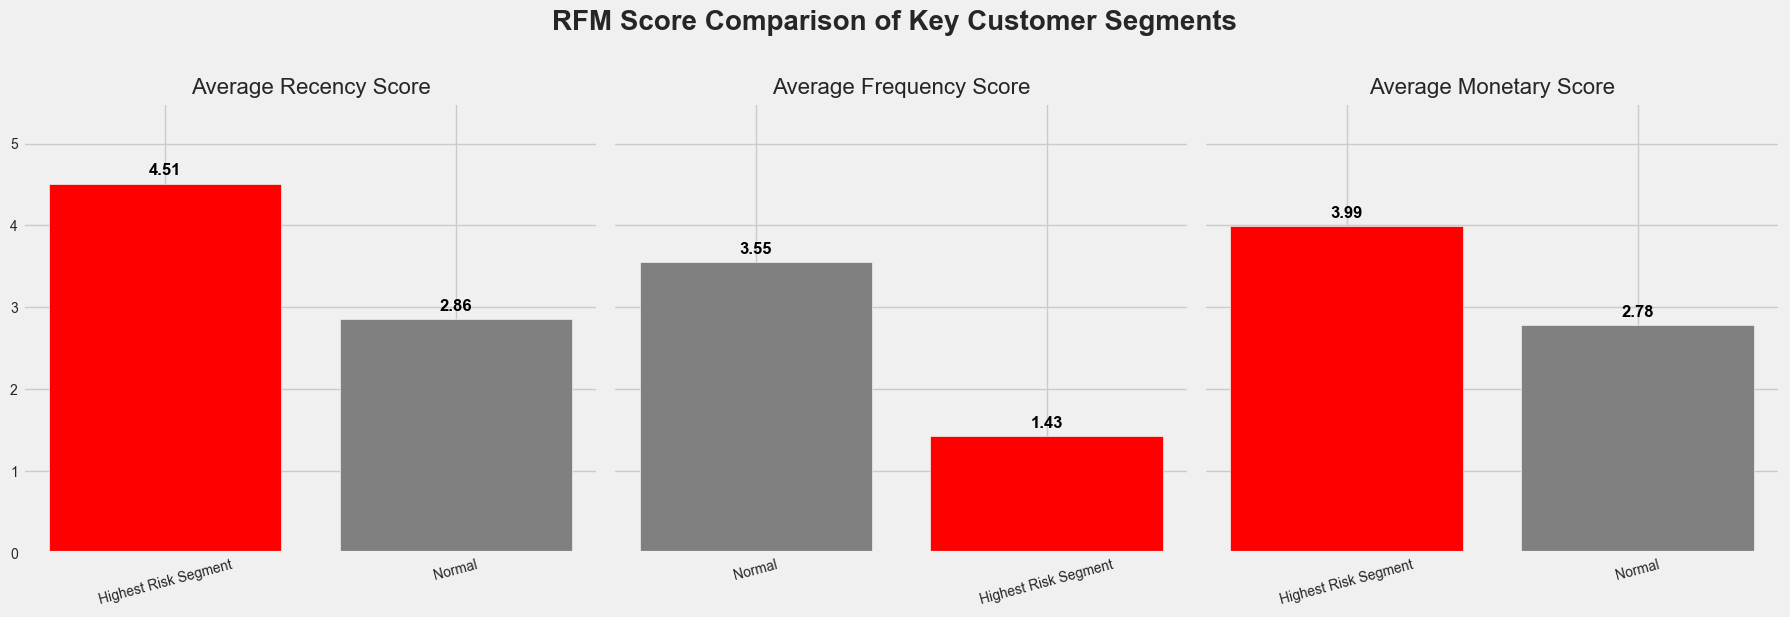

In [45]:
# --- RFM 핵심 세그먼트 비교 대시보드 ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')

# **RFM 세그먼트별 평균 점수 데이터 추출**
user = 'root'
password = '0818'
host = 'localhost'
port = 3306
db = 'finsight'
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}')

rfm_dashboard_query = """
WITH customer_rfm AS (
    SELECT 
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary,
        MAX(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim 
    GROUP BY nameOrig
),
rfm_quartiles AS (
    SELECT 
        customer_id, recency, frequency, monetary, has_fraud,
        CASE NTILE(5) OVER (ORDER BY recency) WHEN 1 THEN 5 WHEN 2 THEN 4 WHEN 3 THEN 3 WHEN 4 THEN 2 WHEN 5 THEN 1 END AS R_score,
        NTILE(5) OVER (ORDER BY frequency) AS F_score,
        NTILE(5) OVER (ORDER BY monetary) AS M_score
    FROM customer_rfm
),
rfm_segments AS (
    SELECT 
        *,
        CASE 
            WHEN R_score >= 4 AND F_score >= 4 AND M_score >= 4 THEN 'VIP'
            WHEN R_score <= 2 AND F_score <= 2 AND M_score <= 2 THEN 'Churn'
            WHEN R_score <= 2 AND F_score <= 2 AND M_score >= 4 THEN 'High-Risk'
            WHEN R_score >= 3 AND F_score <= 2 AND M_score >= 3 THEN 'Highest Risk Segment'
            ELSE 'Normal'
        END AS customer_type
    FROM rfm_quartiles
)
SELECT 
    customer_type,
    ROUND(AVG(R_score), 2) AS R_score,
    ROUND(AVG(F_score), 2) AS F_score,
    ROUND(AVG(M_score), 2) AS M_score,
    COUNT(*) AS customer_count,
    ROUND(SUM(has_fraud) * 100.0 / COUNT(*), 2) AS fraud_rate
FROM rfm_segments
WHERE customer_type IN ('VIP', 'Normal', 'Highest Risk Segment')
GROUP BY customer_type
ORDER BY R_score DESC;
"""
rfm_dashboard_data = pd.read_sql_query(rfm_dashboard_query, engine)

# 시각화 설정 (영문 폰트 사용)
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('RFM Score Comparison of Key Customer Segments', size=20, fontweight='bold', y=1.02)
colors = ['green', 'grey', 'red']
labels = ['VIP', 'Normal', 'Highest Risk Segment']
x_ticks = ['Recency', 'Frequency', 'Monetary']

# --- Recency Score Bar Chart ---
r_scores = rfm_dashboard_data.sort_values(by='R_score', ascending=False)['R_score']
r_segments = rfm_dashboard_data.sort_values(by='R_score', ascending=False)['customer_type']
r_colors = [colors[labels.index(s)] for s in r_segments]
axes[0].bar(r_segments, r_scores, color=r_colors)
axes[0].set_title('Average Recency Score', fontsize=16)
axes[0].set_ylim(0, 5.5)
for i, v in enumerate(r_scores):
    axes[0].text(i, v + 0.1, str(v), color='black', ha='center', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=15)

# --- Frequency Score Bar Chart ---
f_scores = rfm_dashboard_data.sort_values(by='F_score', ascending=False)['F_score']
f_segments = rfm_dashboard_data.sort_values(by='F_score', ascending=False)['customer_type']
f_colors = [colors[labels.index(s)] for s in f_segments]
axes[1].bar(f_segments, f_scores, color=f_colors)
axes[1].set_title('Average Frequency Score', fontsize=16)
axes[1].set_ylim(0, 5.5)
for i, v in enumerate(f_scores):
    axes[1].text(i, v + 0.1, str(v), color='black', ha='center', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=15)

# --- Monetary Score Bar Chart ---
m_scores = rfm_dashboard_data.sort_values(by='M_score', ascending=False)['M_score']
m_segments = rfm_dashboard_data.sort_values(by='M_score', ascending=False)['customer_type']
m_colors = [colors[labels.index(s)] for s in m_segments]
axes[2].bar(m_segments, m_scores, color=m_colors)
axes[2].set_title('Average Monetary Score', fontsize=16)
axes[2].set_ylim(0, 5.5)
for i, v in enumerate(m_scores):
    axes[2].text(i, v + 0.1, str(v), color='black', ha='center', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()



## Recency와 Monetary는 높지만 Frequency는 낮은 고객 -> isFraud

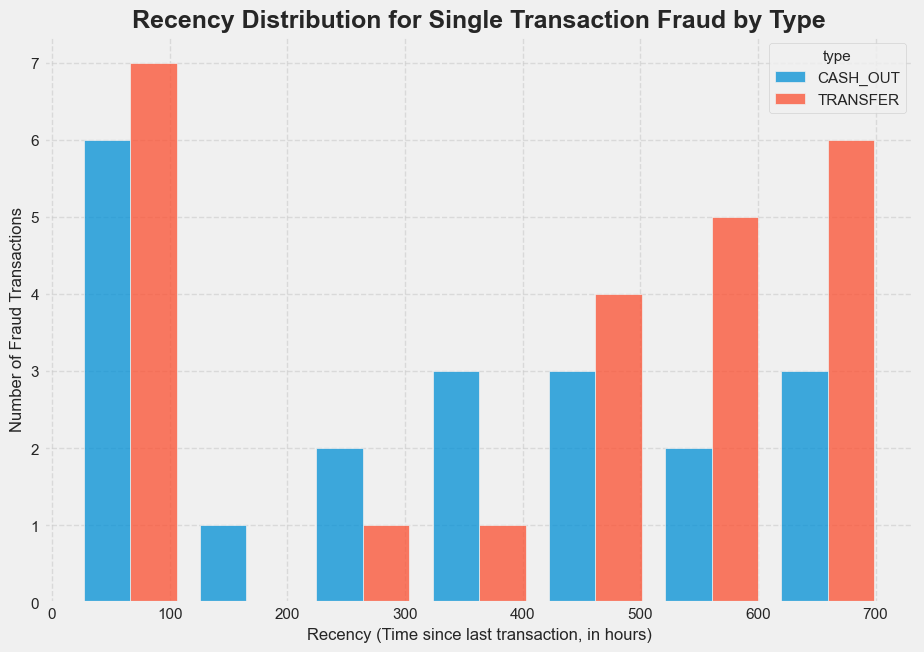

In [54]:
# --- 거래 유형별 사기 거래 Recency 분포 시각화 ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')

# **거래 유형별 사기 거래 RFM 데이터 추출**
user = 'root'
password = '0818'
host = 'localhost'
port = 3306
db = 'finsight'
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}')

type_rfm_query = """
WITH customer_rfm_type AS (
    SELECT
        type,
        nameOrig AS customer_id,
        (SELECT MAX(step) FROM paysim) - MAX(step) AS recency,
        COUNT(*) AS frequency,
        SUM(amount) AS monetary,
        MAX(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS has_fraud
    FROM paysim
    WHERE isFraud = 1 AND type IN ('TRANSFER', 'CASH_OUT')
    GROUP BY type, nameOrig
)
SELECT * FROM customer_rfm_type;
"""
type_rfm_data = pd.read_sql_query(type_rfm_query, engine)

# 시각화 설정
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 11
plt.figure(figsize=(10, 7))

# 단발성(Frequency=1) 거래 데이터만 필터링
freq1_data = type_rfm_data[type_rfm_data['frequency'] == 1]

# 히스토그램 그리기
sns.histplot(data=freq1_data, x='recency', hue='type', multiple='dodge', shrink=0.8)

# 축 및 제목 설정
plt.title('Recency Distribution for Single Transaction Fraud by Type', fontsize=18, fontweight='bold')
plt.xlabel('Recency (Time since last transaction, in hours)', fontsize=12)
plt.ylabel('Number of Fraud Transactions', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


## Transfer는 양극단, Cash out은 최근 거래에 압도적으로 집중되어 있음. 

     amount_range  fraud_count  total_transactions  fraud_rate_percent
0         1. < 1K          0.0                 600            0.000000
1     2. 1K - 10K          1.0                4644            0.021533
2    3. 10K - 50K          3.0                6205            0.048348
3   4. 50K - 100K          6.0                3008            0.199468
4  5. 100K - 500K         12.0               10231            0.117291
5    6. 500K - 1M          9.0                 861            1.045296
6         7. > 1M         13.0                 505            2.574257


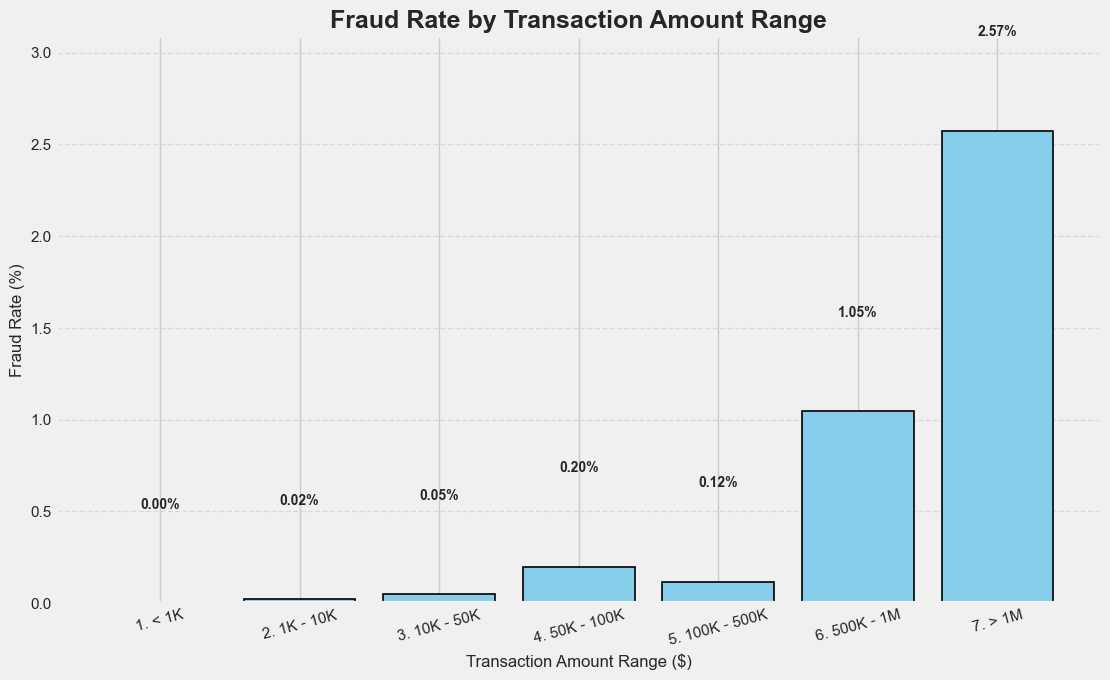

In [48]:
# --- 거래 금액 구간별 사기율 시각화 ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')

# **거래 금액 구간별 사기 데이터 추출**
user = 'root'
password = '0818'
host = 'localhost'
port = 3306
db = 'finsight'
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}')

monetary_fraud_query = """
SELECT
    -- 금액 구간을 분류
    CASE
        WHEN amount <= 1000 THEN '1. < 1K'
        WHEN amount > 1000 AND amount <= 10000 THEN '2. 1K - 10K'
        WHEN amount > 10000 AND amount <= 50000 THEN '3. 10K - 50K'
        WHEN amount > 50000 AND amount <= 100000 THEN '4. 50K - 100K'
        WHEN amount > 100000 AND amount <= 500000 THEN '5. 100K - 500K'
        WHEN amount > 500000 AND amount <= 1000000 THEN '6. 500K - 1M'
        WHEN amount > 1000000 THEN '7. > 1M'
        ELSE 'Others'
    END AS amount_range,
    SUM(isFraud) AS fraud_count,
    COUNT(*) AS total_transactions
FROM paysim
GROUP BY amount_range
ORDER BY amount_range;
"""
monetary_fraud_data = pd.read_sql_query(monetary_fraud_query, engine)
monetary_fraud_data['fraud_rate_percent'] = (monetary_fraud_data['fraud_count'] / monetary_fraud_data['total_transactions']) * 100

print(monetary_fraud_data)

# 시각화 설정 (영문 폰트 사용)
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 11
plt.figure(figsize=(12, 7))

# 막대 그래프 그리기
bars = plt.bar(monetary_fraud_data['amount_range'], monetary_fraud_data['fraud_rate_percent'],
           color='skyblue', edgecolor='black', linewidth=1.2)

# 바 위에 데이터 레이블 추가
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5,
             f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 축 및 제목 설정
plt.title('Fraud Rate by Transaction Amount Range', size=18, fontweight='bold')
plt.xlabel('Transaction Amount Range ($)', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.xticks(rotation=15)
plt.ylim(0, monetary_fraud_data['fraud_rate_percent'].max() * 1.2) # y축 범위 조정
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()



## 거래 금액이 높을수록 사기 위험이 극적으로 커짐.